# Anomaly detection

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import warnings 
from datetime import datetime
warnings.filterwarnings('ignore')

## File location
#### File: s3://utah/supercdms-data/CDMS/UMN/R68/Raw/07180813_0958/07180813_0958_F0008/events/00001/banks/SCD0/data.npz

In [2]:
# load data using numpy
npz = np.load('data.npz')
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient='columns')
print("Number of values: ", df.shape[0])

Number of values:  1569218


In [3]:
# creating datetime index
index = pd.date_range("1/1/2000",periods=df.shape[0], freq='1S')

In [4]:
# Creating train and test dataframes
df.index = index
new_df = df.iloc[:int(df.shape[0]*0.98)]
test_df = df.iloc[int(df.shape[0]*0.98):]
print(new_df.shape, test_df.shape)

(1537833, 1) (31385, 1)


In [5]:
# final data frame: frequency estimation
final_df = new_df.asfreq(pd.infer_freq(new_df.index))

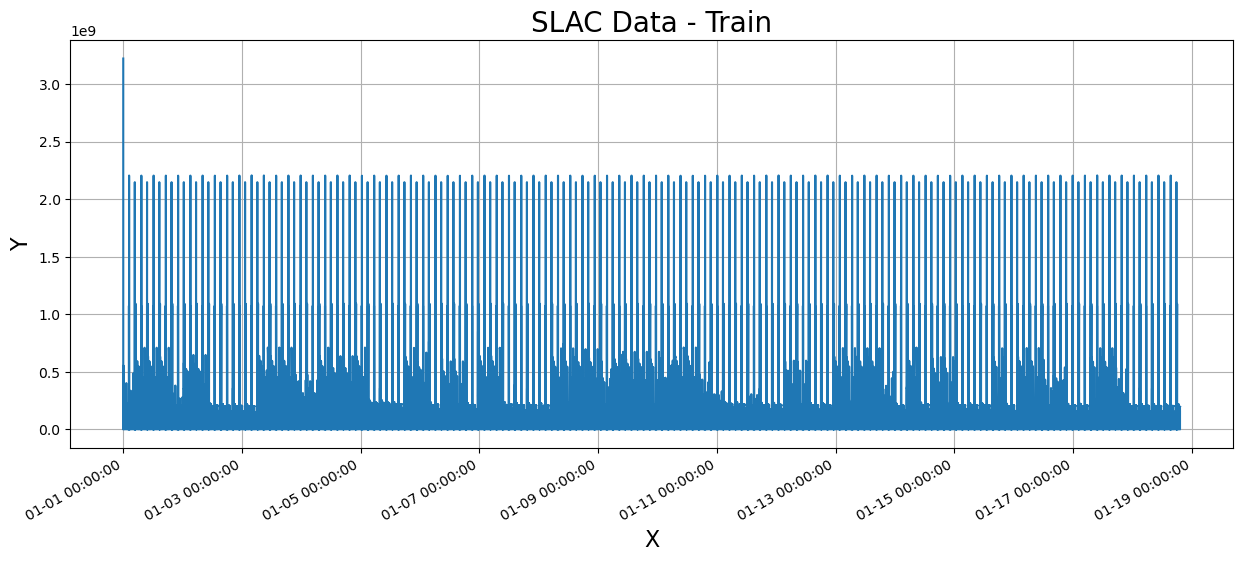

In [6]:
# plot train data
myFmt = mdates.DateFormatter('%m-%d %H:%M:%S')
plt.figure(figsize=(15,6))
plt.plot(final_df)
plt.title('SLAC Data - Train', fontsize=20)
plt.ylabel('Y', fontsize=16)
plt.xlabel('X', fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

## Isolation forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [7]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [8]:
# set contamination factor
outliers_fraction = float(.01)

In [9]:

scaler = StandardScaler()
np_scaled = scaler.fit_transform(final_df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [10]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

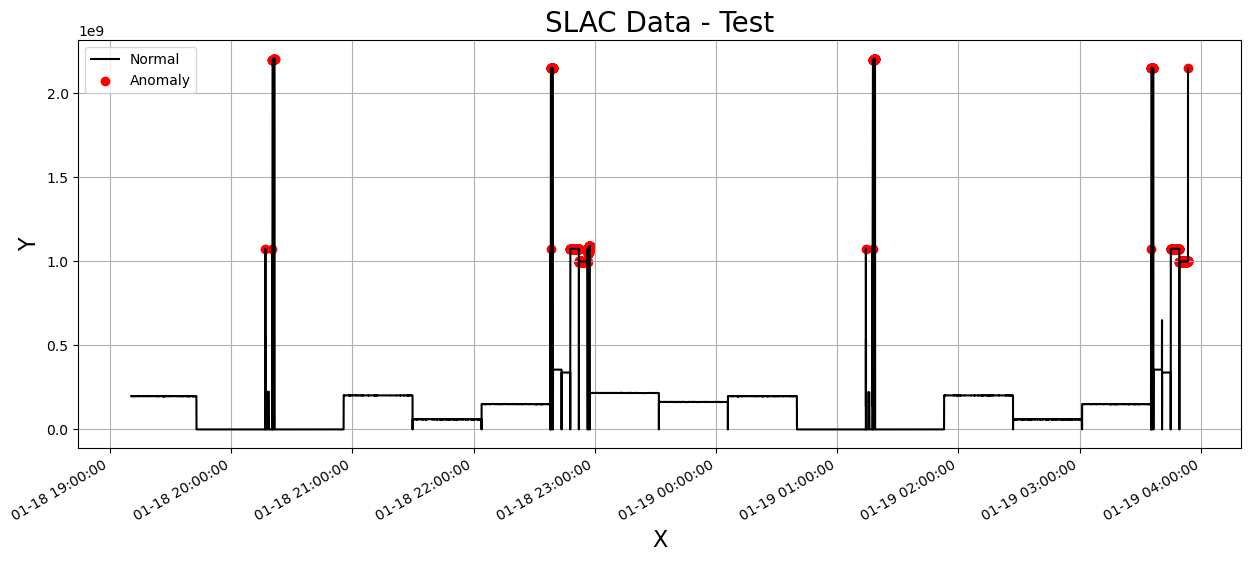

In [11]:
# model prediction
np_scaled = scaler.fit_transform(test_df.values.reshape(-1, 1))
data_test = pd.DataFrame(np_scaled)
test_df['anomaly'] = model.predict(data_test)

# visualization
fig, ax = plt.subplots(figsize=(15,6))
a = test_df.loc[test_df['anomaly'] == -1, ['data']] #anomalies
ax.plot(test_df.index, test_df['data'], color='black', label = 'Normal')
ax.scatter(a.index,a['data'], color='red', label = 'Anomaly')
plt.legend()
plt.grid()
myFmt = mdates.DateFormatter('%m-%d %H:%M:%S')
plt.title('SLAC Data - Test', fontsize=20)
plt.ylabel('Y', fontsize=16)
plt.xlabel('X', fontsize=16)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.show()